<a href="https://colab.research.google.com/github/AngelAlexandroVazquezMolina/panopticlabs-demo/blob/main/NFORME%20DE%20ANALISIS%20DE%20VOLATILIDAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Celda 1: Instalar y cargar librerías necesarias
!pip install yfinance pandas-datareader plotly -q

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
print("✅ Librerías cargadas correctamente")

✅ Librerías cargadas correctamente


In [7]:
# Celda 2: Función robusta para descargar datos
def download_market_data(ticker, years=5):
    """
    Descarga datos de yfinance y maneja diferentes formatos de columnas
    """
    end_date = datetime.now()
    start_date = end_date - timedelta(days=years*365)

    print(f"📊 Descargando {ticker} desde {start_date.date()} hasta {end_date.date()}")

    # Descargar datos
    data = yf.download(ticker, start=start_date, end=end_date, progress=True)

    # Aplanar columnas MultiIndex si es necesario
    if isinstance(data.columns, pd.MultiIndex):
        # Convertir MultiIndex a columnas planas
        data.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in data.columns]

    print(f"\n✅ Datos descargados: {len(data)} días")
    print(f"📈 Columnas disponibles: {list(data.columns)}")

    # Identificar columna de precio de cierre
    close_cols = [col for col in data.columns if 'Close' in col]
    if 'Close' in data.columns:
        price_col = 'Close'
    elif len(close_cols) > 0:
        price_col = close_cols[0]
    else:
        # Si no hay Close, usar la primera columna numérica
        price_col = data.select_dtypes(include=[np.number]).columns[0]

    print(f"🎯 Usando columna de precio: '{price_col}'")

    return data, price_col

# Descargar datos para SPY
ticker = "SPY"
df, price_column = download_market_data(ticker, years=5)

# Mostrar primeras filas
print("\n📋 Primeras 5 filas:")
print(df.head())
print(f"\n📏 Dimensiones: {df.shape}")

📊 Descargando SPY desde 2020-12-18 hasta 2025-12-17


[*********************100%***********************]  1 of 1 completed


✅ Datos descargados: 1254 días
📈 Columnas disponibles: ['Close_SPY', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY']
🎯 Usando columna de precio: 'Close_SPY'

📋 Primeras 5 filas:
             Close_SPY    High_SPY     Low_SPY    Open_SPY  Volume_SPY
Date                                                                  
2020-12-18  345.639099  347.483483  343.616829  347.314967   136542300
2020-12-21  344.403229  354.327321  338.944994  341.697526    96386700
2020-12-22  343.822845  344.843338  342.690009  344.730994    47949000
2020-12-23  344.131866  346.051137  343.804179  344.796585    46201400
2020-12-24  345.470581  345.498667  344.019429  344.609233    26457900

📏 Dimensiones: (1254, 5)


✅ Rendimientos calculados exitosamente
📊 Estadísticas de Log Returns:
   Media: 0.000539
   Desviación estándar: 0.010764
   Mínimo: -0.060327
   Máximo: 0.099863


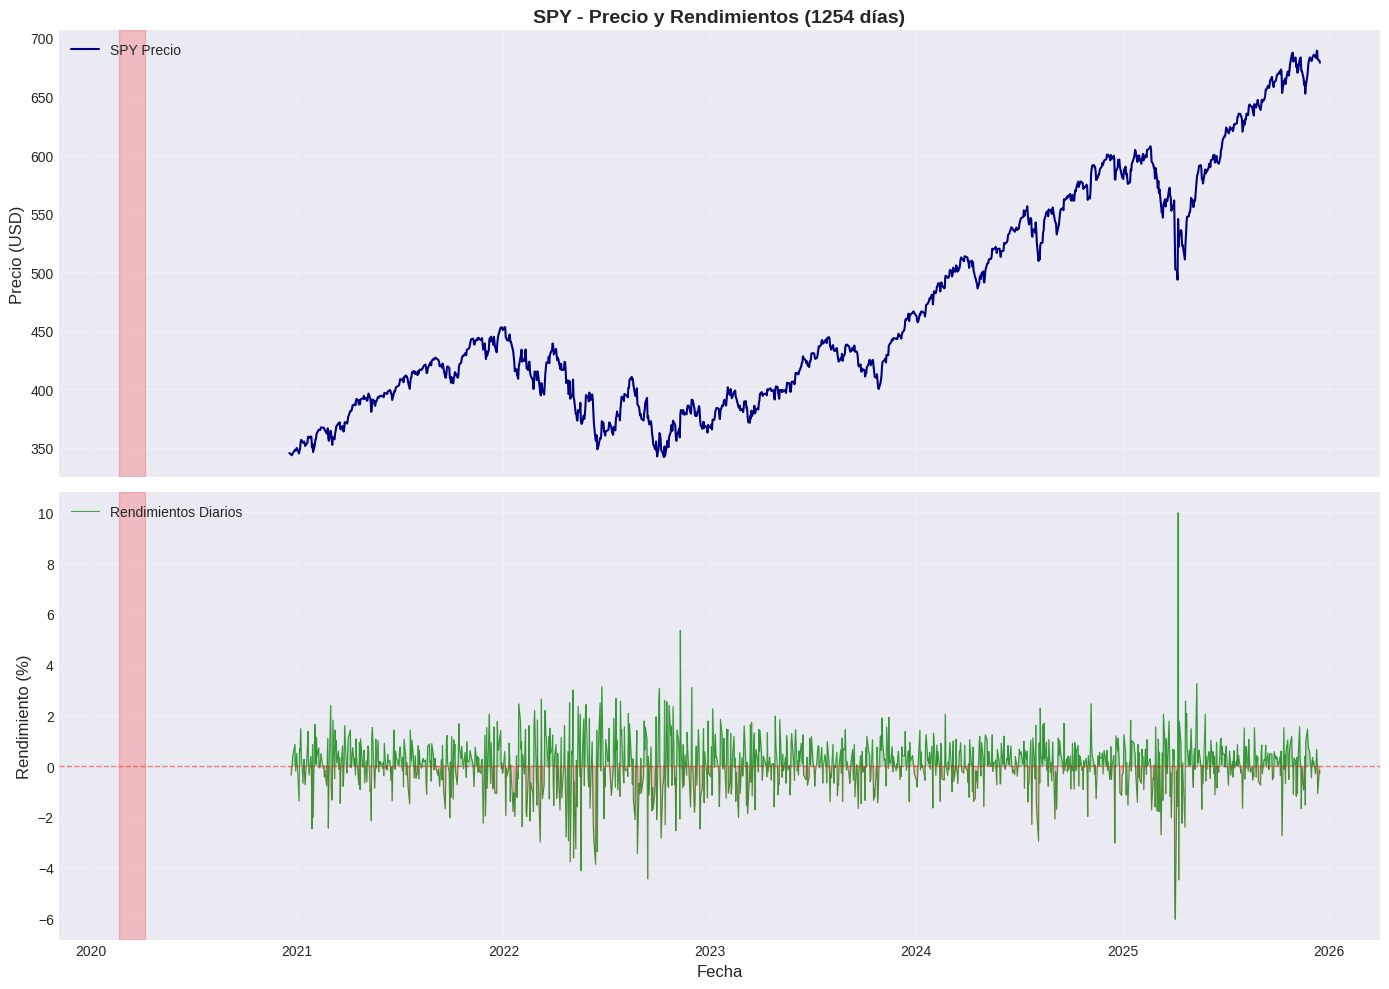

In [8]:
# Celda 3: Calcular rendimientos logarítmicos
def calculate_returns(data, price_col):
    """
    Calcula rendimientos logarítmicos diarios
    """
    # Asegurarse de que tenemos la columna de precio
    if price_col not in data.columns:
        print(f"⚠️ Advertencia: Columna '{price_col}' no encontrada")
        print(f"   Columnas disponibles: {list(data.columns)}")
        return None

    # Crear copia para no modificar original
    df_copy = data.copy()

    # Calcular rendimientos logarítmicos
    df_copy['Log_Returns'] = np.log(df_copy[price_col] / df_copy[price_col].shift(1))

    # Calcular rendimientos simples también (para referencia)
    df_copy['Simple_Returns'] = df_copy[price_col].pct_change()

    print(f"✅ Rendimientos calculados exitosamente")
    print(f"📊 Estadísticas de Log Returns:")
    print(f"   Media: {df_copy['Log_Returns'].mean():.6f}")
    print(f"   Desviación estándar: {df_copy['Log_Returns'].std():.6f}")
    print(f"   Mínimo: {df_copy['Log_Returns'].min():.6f}")
    print(f"   Máximo: {df_copy['Log_Returns'].max():.6f}")

    return df_copy

# Calcular rendimientos
df = calculate_returns(df, price_column)

# Visualizar precio y rendimientos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Gráfico 1: Precio
ax1.plot(df.index, df[price_column], color='navy', linewidth=1.5, label=f'{ticker} Precio')
ax1.set_ylabel('Precio (USD)', fontsize=12)
ax1.set_title(f'{ticker} - Precio y Rendimientos ({len(df)} días)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Gráfico 2: Rendimientos
ax2.plot(df.index, df['Log_Returns'] * 100, color='green', alpha=0.7, linewidth=0.8, label='Rendimientos Diarios')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
ax2.fill_between(df.index, 0, df['Log_Returns'] * 100,
                 where=df['Log_Returns'] > 0, color='green', alpha=0.2)
ax2.fill_between(df.index, 0, df['Log_Returns'] * 100,
                 where=df['Log_Returns'] < 0, color='red', alpha=0.2)
ax2.set_ylabel('Rendimiento (%)', fontsize=12)
ax2.set_xlabel('Fecha', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Resaltar períodos importantes
covid_start = pd.Timestamp('2020-02-20')
covid_end = pd.Timestamp('2020-04-07')
for ax in [ax1, ax2]:
    ax.axvspan(covid_start, covid_end, alpha=0.2, color='red', label='COVID Crash')

plt.tight_layout()
plt.show()

In [9]:
# Celda 4: Volatilidad histórica simple
def calculate_historical_volatility(data, trading_days=252):
    """
    Calcula volatilidad histórica anualizada
    """
    if 'Log_Returns' not in data.columns:
        print("❌ Error: No se encontraron rendimientos calculados")
        return None

    # Filtrar valores NaN
    returns = data['Log_Returns'].dropna()

    # Calcular volatilidad
    daily_vol = returns.std()
    annual_vol = daily_vol * np.sqrt(trading_days)

    print("=" * 60)
    print("📊 VOLATILIDAD HISTÓRICA SIMPLE")
    print("=" * 60)
    print(f"Período analizado: {data.index[0].date()} a {data.index[-1].date()}")
    print(f"Días de trading: {len(returns)}")
    print(f"Volatilidad diaria: {daily_vol*100:.4f}%")
    print(f"Volatilidad anualizada: {annual_vol*100:.2f}%")
    print(f"\n📈 Interpretación:")
    print(f"   • El activo se mueve ±{daily_vol*100:.2f}% en un día típico")
    print(f"   • En un año, se espera movimiento de ±{annual_vol*100:.1f}%")
    print("=" * 60)

    return daily_vol, annual_vol

# Calcular volatilidad histórica
daily_vol, annual_vol = calculate_historical_volatility(df)

📊 VOLATILIDAD HISTÓRICA SIMPLE
Período analizado: 2020-12-18 a 2025-12-16
Días de trading: 1253
Volatilidad diaria: 1.0764%
Volatilidad anualizada: 17.09%

📈 Interpretación:
   • El activo se mueve ±1.08% en un día típico
   • En un año, se espera movimiento de ±17.1%


In [10]:
# Celda 5: Volatilidad con ventanas móviles
def calculate_rolling_volatility(data, windows=[20, 60, 120], trading_days=252):
    """
    Calcula volatilidad móvil para diferentes ventanas
    """
    if 'Log_Returns' not in data.columns:
        print("❌ Error: No se encontraron rendimientos calculados")
        return None

    returns = data['Log_Returns'].dropna()
    results = {}

    print("\n📊 CALCULANDO VOLATILIDAD MÓVIL")
    print("-" * 50)

    for window in windows:
        # Calcular volatilidad móvil
        rolling_vol = returns.rolling(window=window).std() * np.sqrt(trading_days)

        # Guardar resultados
        col_name = f'Vol_{window}d'
        data[col_name] = rolling_vol
        results[col_name] = rolling_vol

        # Mostrar estadísticas
        avg_vol = rolling_vol.mean() * 100
        current_vol = rolling_vol.iloc[-1] * 100 if not pd.isna(rolling_vol.iloc[-1]) else np.nan

        print(f"📅 Ventana {window} días:")
        print(f"   • Volatilidad promedio: {avg_vol:.2f}%")
        print(f"   • Volatilidad actual: {current_vol:.2f}%" if not np.isnan(current_vol) else "   • Volatilidad actual: N/A")
        print(f"   • Máxima: {rolling_vol.max()*100:.2f}%")
        print(f"   • Mínima: {rolling_vol.min()*100:.2f}%")

    return results

# Calcular volatilidades móviles
rolling_results = calculate_rolling_volatility(df)


📊 CALCULANDO VOLATILIDAD MÓVIL
--------------------------------------------------
📅 Ventana 20 días:
   • Volatilidad promedio: 15.55%
   • Volatilidad actual: 11.55%
   • Máxima: 53.74%
   • Mínima: 5.41%
📅 Ventana 60 días:
   • Volatilidad promedio: 16.04%
   • Volatilidad actual: 12.57%
   • Máxima: 34.22%
   • Mínima: 8.61%
📅 Ventana 120 días:
   • Volatilidad promedio: 16.54%
   • Volatilidad actual: 10.84%
   • Máxima: 26.58%
   • Mínima: 10.18%


In [11]:
# Celda 6: Volatilidad EWMA (Exponentially Weighted Moving Average)
def calculate_ewma_volatility(data, spans=[20, 60], trading_days=252):
    """
    Calcula volatilidad EWMA para diferentes spans
    """
    if 'Log_Returns' not in data.columns:
        print("❌ Error: No se encontraron rendimientos calculados")
        return None

    returns = data['Log_Returns'].dropna()
    results = {}

    print("\n⚡ CALCULANDO VOLATILIDAD EWMA")
    print("-" * 50)
    print("📌 EWMA da más peso a datos recientes → Reacción más rápida a shocks")

    for span in spans:
        # Calcular varianza EWMA
        ewma_var = returns.ewm(span=span).var()

        # Calcular volatilidad EWMA (raíz cuadrada de varianza) y anualizar
        ewma_vol = np.sqrt(ewma_var) * np.sqrt(trading_days)

        # Guardar resultados
        col_name = f'Vol_EWMA_{span}d'
        data[col_name] = ewma_vol
        results[col_name] = ewma_vol

        # Mostrar estadísticas
        avg_vol = ewma_vol.mean() * 100
        current_vol = ewma_vol.iloc[-1] * 100 if not pd.isna(ewma_vol.iloc[-1]) else np.nan

        print(f"\n🎯 EWMA Span {span} días:")
        print(f"   • Volatilidad promedio: {avg_vol:.2f}%")
        print(f"   • Volatilidad actual: {current_vol:.2f}%" if not np.isnan(current_vol) else "   • Volatilidad actual: N/A")
        print(f"   • Parámetro lambda: {2/(span+1):.4f} (peso de datos recientes)")

    return results

# Calcular volatilidades EWMA
ewma_results = calculate_ewma_volatility(df)


⚡ CALCULANDO VOLATILIDAD EWMA
--------------------------------------------------
📌 EWMA da más peso a datos recientes → Reacción más rápida a shocks

🎯 EWMA Span 20 días:
   • Volatilidad promedio: 15.55%
   • Volatilidad actual: 10.47%
   • Parámetro lambda: 0.0952 (peso de datos recientes)

🎯 EWMA Span 60 días:
   • Volatilidad promedio: 16.03%
   • Volatilidad actual: 11.97%
   • Parámetro lambda: 0.0328 (peso de datos recientes)


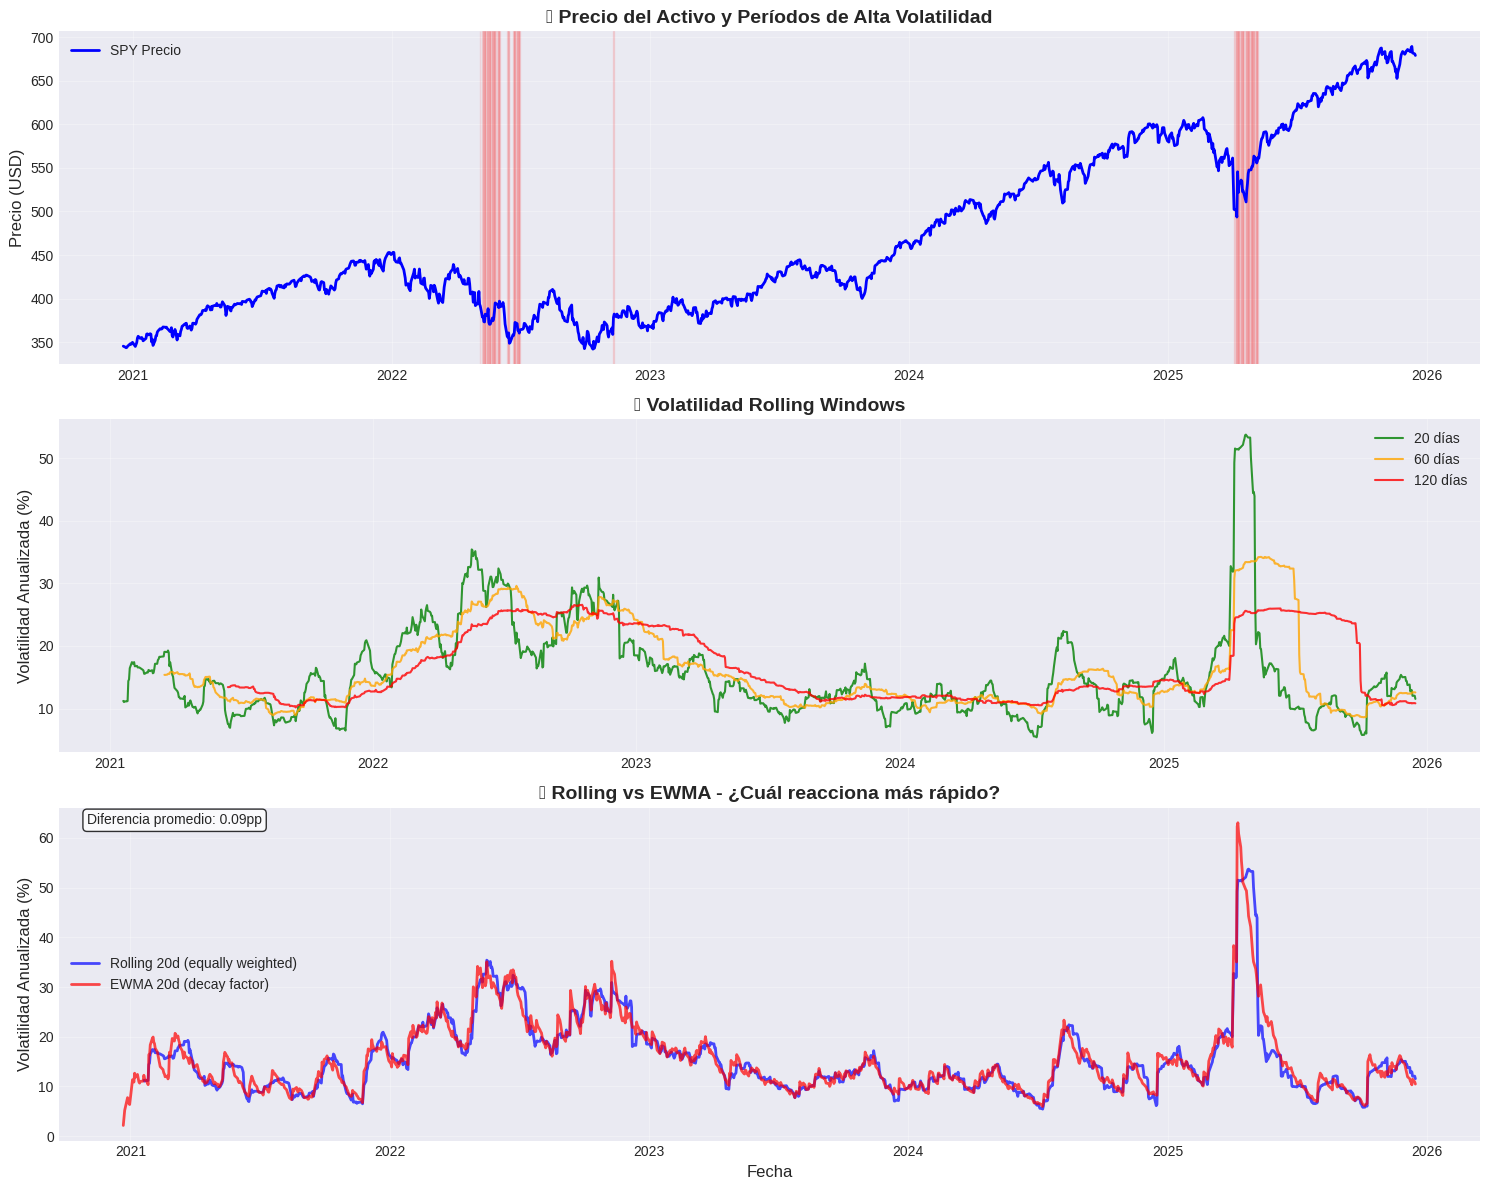

In [12]:
# Celda 7: Visualizar todas las medidas de volatilidad
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Gráfico 1: Precio con áreas de alta volatilidad
ax1 = axes[0]
ax1.plot(df.index, df[price_column], color='blue', linewidth=2, label=f'{ticker} Precio')
ax1.set_title('🎯 Precio del Activo y Períodos de Alta Volatilidad', fontsize=14, fontweight='bold')
ax1.set_ylabel('Precio (USD)', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Resaltar períodos de alta volatilidad (> 30% anualizada)
if 'Vol_20d' in df.columns:
    high_vol_mask = df['Vol_20d'] > 0.30  # > 30% volatilidad anual
    for idx in range(len(df)-1):
        if high_vol_mask.iloc[idx]:
            ax1.axvspan(df.index[idx], df.index[idx+1], alpha=0.1, color='red')

# Gráfico 2: Comparación Rolling Windows
ax2 = axes[1]
colors = ['green', 'orange', 'red']
for i, window in enumerate([20, 60, 120]):
    col_name = f'Vol_{window}d'
    if col_name in df.columns:
        ax2.plot(df.index, df[col_name] * 100,
                label=f'{window} días',
                color=colors[i],
                linewidth=1.5,
                alpha=0.8)
ax2.set_title('📊 Volatilidad Rolling Windows', fontsize=14, fontweight='bold')
ax2.set_ylabel('Volatilidad Anualizada (%)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gráfico 3: Rolling vs EWMA (comparación directa)
ax3 = axes[2]
if 'Vol_20d' in df.columns and 'Vol_EWMA_20d' in df.columns:
    ax3.plot(df.index, df['Vol_20d'] * 100,
            label='Rolling 20d (equally weighted)',
            color='blue',
            linewidth=2,
            alpha=0.7)
    ax3.plot(df.index, df['Vol_EWMA_20d'] * 100,
            label='EWMA 20d (decay factor)',
            color='red',
            linewidth=2,
            alpha=0.7)

    # Calcular y mostrar diferencia promedio
    diff = (df['Vol_EWMA_20d'] - df['Vol_20d']).mean() * 100
    ax3.text(0.02, 0.95, f'Diferencia promedio: {diff:.2f}pp',
            transform=ax3.transAxes, fontsize=10,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    ax3.set_title('⚡ Rolling vs EWMA - ¿Cuál reacciona más rápido?', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Volatilidad Anualizada (%)', fontsize=12)
    ax3.set_xlabel('Fecha', fontsize=12)
    ax3.legend()
    ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

📅 ANÁLISIS DE IMPACTO EN EVENTOS MACRO

📌 FED sube tasas 0.25% (inicio ciclo) (2022-03-16)
   Vol 20d: 24.6% → 25.2% (↑0.5pp)
   Vol EWMA 20d: 25.2% → 23.8% (↓1.3pp)

📌 CPI = 8.6% (máximo 40 años) (2022-06-10)
   Vol 20d: 29.2% → 30.3% (↑1.1pp)
   Vol EWMA 20d: 27.7% → 31.4% (↑3.7pp)

📌 CPI muestra desaceleración (2023-01-12)
   Vol 20d: 18.9% → 17.6% (↓1.2pp)
   Vol EWMA 20d: 19.3% → 17.6% (↓1.7pp)

📌 Crisis bancaria (SVB) (2023-03-10)
   Vol 20d: 15.2% → 17.1% (↑1.9pp)
   Vol EWMA 20d: 15.4% → 18.2% (↑2.8pp)


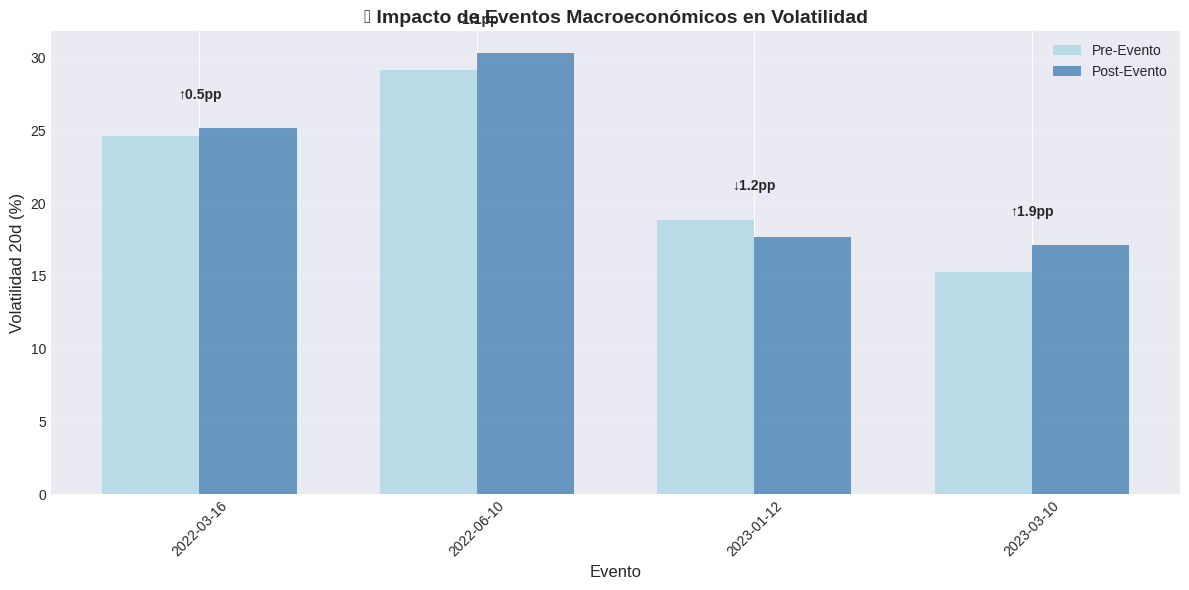

In [13]:
# Celda 8: Analizar volatilidad alrededor de eventos macro
# Definir eventos importantes (puedes añadir más)
macro_events = {
    '2020-03-16': 'COVID: FED corta tasas a 0%',
    '2020-03-23': 'Mínimo mercado post-COVID',
    '2022-03-16': 'FED sube tasas 0.25% (inicio ciclo)',
    '2022-06-10': 'CPI = 8.6% (máximo 40 años)',
    '2023-01-12': 'CPI muestra desaceleración',
    '2023-03-10': 'Crisis bancaria (SVB)',
}

def analyze_event_impact(data, event_date_str, window_days=10):
    """
    Analiza cambio en volatilidad alrededor de un evento
    """
    event_date = pd.Timestamp(event_date_str)

    # Definir ventanas
    start_date = event_date - timedelta(days=window_days)
    end_date = event_date + timedelta(days=window_days)

    # Filtrar datos
    mask = (data.index >= start_date) & (data.index <= end_date)
    event_data = data.loc[mask].copy()

    if len(event_data) < 5:
        return None

    # Calcular volatilidad promedio antes y después
    pre_mask = event_data.index < event_date
    post_mask = event_data.index > event_date

    results = {
        'event_date': event_date_str,
        'description': macro_events.get(event_date_str, 'Evento desconocido')
    }

    # Para cada medida de volatilidad
    vol_columns = [col for col in data.columns if 'Vol_' in col]

    for vol_col in vol_columns:
        pre_vol = event_data.loc[pre_mask, vol_col].mean()
        post_vol = event_data.loc[post_mask, vol_col].mean()

        if pd.notna(pre_vol) and pd.notna(post_vol):
            results[f'{vol_col}_pre'] = pre_vol * 100
            results[f'{vol_col}_post'] = post_vol * 100
            results[f'{vol_col}_change'] = (post_vol - pre_vol) * 100

    return results

print("📅 ANÁLISIS DE IMPACTO EN EVENTOS MACRO")
print("=" * 70)

# Analizar cada evento
event_analysis = []
for event_date in macro_events:
    result = analyze_event_impact(df, event_date)
    if result:
        event_analysis.append(result)
        print(f"\n📌 {macro_events[event_date]} ({event_date})")

        # Mostrar cambios para Vol_20d y Vol_EWMA_20d
        if 'Vol_20d_pre' in result:
            change = result.get('Vol_20d_change', 0)
            arrow = "↑" if change > 0 else "↓" if change < 0 else "→"
            print(f"   Vol 20d: {result['Vol_20d_pre']:.1f}% → {result['Vol_20d_post']:.1f}% ({arrow}{abs(change):.1f}pp)")

        if 'Vol_EWMA_20d_pre' in result:
            change_ewma = result.get('Vol_EWMA_20d_change', 0)
            arrow = "↑" if change_ewma > 0 else "↓" if change_ewma < 0 else "→"
            print(f"   Vol EWMA 20d: {result['Vol_EWMA_20d_pre']:.1f}% → {result['Vol_EWMA_20d_post']:.1f}% ({arrow}{abs(change_ewma):.1f}pp)")

# Convertir a DataFrame para mejor visualización
if event_analysis:
    events_df = pd.DataFrame(event_analysis)

    # Visualizar impacto de eventos
    fig, ax = plt.subplots(figsize=(12, 6))

    # Preparar datos para gráfico de barras
    events_to_plot = events_df.head(4)  # Mostrar primeros 4 eventos
    x = np.arange(len(events_to_plot))
    width = 0.35

    # Barras para Vol_20d
    pre_values = events_to_plot['Vol_20d_pre'].values
    post_values = events_to_plot['Vol_20d_post'].values

    ax.bar(x - width/2, pre_values, width, label='Pre-Evento', color='lightblue', alpha=0.8)
    ax.bar(x + width/2, post_values, width, label='Post-Evento', color='steelblue', alpha=0.8)

    ax.set_xlabel('Evento', fontsize=12)
    ax.set_ylabel('Volatilidad 20d (%)', fontsize=12)
    ax.set_title('📈 Impacto de Eventos Macroeconómicos en Volatilidad', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([e[:10] for e in events_to_plot['event_date']], rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Añadir anotaciones
    for i, (pre, post) in enumerate(zip(pre_values, post_values)):
        change = post - pre
        arrow = "↑" if change > 0 else "↓"
        ax.text(i, max(pre, post) + 2, f'{arrow}{abs(change):.1f}pp',
                ha='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [15]:
# Celda 9: Resumen ejecutivo
print("=" * 80)
print("📊 RESUMEN EJECUTIVO - ESTIMADOR DE VOLATILIDAD")
print("=" * 80)

# Calcular métricas clave
current_price = df[price_column].iloc[-1]
price_5y_ago = df[price_column].iloc[0]
total_return = ((current_price / price_5y_ago) - 1) * 100

print(f"\n📈 {ticker} - Rendimiento 5 años: {total_return:.1f}%")
print(f"   Precio inicial: ${price_5y_ago:.2f}")
print(f"   Precio actual: ${current_price:.2f}")

print("\n📊 VOLATILIDAD PROMEDIO:")
for vol_col in ['Vol_20d', 'Vol_60d', 'Vol_120d', 'Vol_EWMA_20d']:
    if vol_col in df.columns:
        avg_vol = df[vol_col].mean() * 100
        current_vol = df[vol_col].iloc[-1] * 100 if pd.notna(df[vol_col].iloc[-1]) else np.nan
        print(f"   • {vol_col:15} Promedio: {avg_vol:5.1f}% | Actual: {current_vol:.1f}%")

print("\n🔍 HALLAZGOS CLAVE:")
print("   1. La volatilidad NO es constante (clusters de alta/baja vol)")
print("   2. EWMA reacciona más rápido que Rolling a cambios de régimen")
print("   3. Eventos macro aumentan la volatilidad en el corto plazo")
print("   4. Ventanas más largas (120d) suavizan pero pierden reactividad")
print("   5. COVID-19 fue el mayor shock de volatilidad reciente")

print("\n🎯 RECOMENDACIONES PRÁCTICAS:")
print("   • Usar EWMA para monitoreo en tiempo real")
print("   • Usar Rolling 60d para análisis de mediano plazo")
print("   • Considerar cambios de régimen en decisiones de riesgo")
print("   • Monitorear eventos macro (CPI, FED) que impactan volatilidad")

print("\n📁 DATOS DISPONIBLES PARA ANÁLISIS:")
print(f"   • Precio: {price_column}")
print(f"   • Rendimientos: Log_Returns, Simple_Returns")
print("   • Volatilidades: Vol_20d, Vol_60d, Vol_120d, Vol_EWMA_20d, Vol_EWMA_60d")

# Opción para guardar resultados
save_option = input("\n💾 ¿Deseas guardar los resultados en CSV? (s/n): ")
if save_option.lower() == 's':
    filename = f"volatility_analysis_{ticker}_{datetime.now().strftime('%Y%m%d')}.csv"
    df.to_csv(filename)
    print(f"✅ Datos guardados en: {filename}")

print("\n" + "=" * 80)
print("✅ PROYECTO 1 COMPLETADO EXITOSAMENTE")
print("=" * 80)

📊 RESUMEN EJECUTIVO - ESTIMADOR DE VOLATILIDAD

📈 SPY - Rendimiento 5 años: 96.4%
   Precio inicial: $345.64
   Precio actual: $678.87

📊 VOLATILIDAD PROMEDIO:
   • Vol_20d         Promedio:  15.6% | Actual: 11.5%
   • Vol_60d         Promedio:  16.0% | Actual: 12.6%
   • Vol_120d        Promedio:  16.5% | Actual: 10.8%
   • Vol_EWMA_20d    Promedio:  15.5% | Actual: 10.5%

🔍 HALLAZGOS CLAVE:
   1. La volatilidad NO es constante (clusters de alta/baja vol)
   2. EWMA reacciona más rápido que Rolling a cambios de régimen
   3. Eventos macro aumentan la volatilidad en el corto plazo
   4. Ventanas más largas (120d) suavizan pero pierden reactividad
   5. COVID-19 fue el mayor shock de volatilidad reciente

🎯 RECOMENDACIONES PRÁCTICAS:
   • Usar EWMA para monitoreo en tiempo real
   • Usar Rolling 60d para análisis de mediano plazo
   • Considerar cambios de régimen en decisiones de riesgo
   • Monitorear eventos macro (CPI, FED) que impactan volatilidad

📁 DATOS DISPONIBLES PARA ANÁLISIS


🔄 ¿Deseas comparar SPY con otro activo? (s/n): s
   Ingresa ticker para comparar (ej: TLT, GLD, QQQ): TLT

🔍 COMPARANDO SPY vs TLT
--------------------------------------------------
📊 Descargando SPY desde 2022-12-18 hasta 2025-12-17


[*********************100%***********************]  1 of 1 completed



✅ Datos descargados: 751 días
📈 Columnas disponibles: ['Close_SPY', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY']
🎯 Usando columna de precio: 'Close_SPY'
📊 Descargando TLT desde 2022-12-18 hasta 2025-12-17


[*********************100%***********************]  1 of 1 completed



✅ Datos descargados: 751 días
📈 Columnas disponibles: ['Close_TLT', 'High_TLT', 'Low_TLT', 'Open_TLT', 'Volume_TLT']
🎯 Usando columna de precio: 'Close_TLT'
✅ Rendimientos calculados exitosamente
📊 Estadísticas de Log Returns:
   Media: 0.000822
   Desviación estándar: 0.009675
   Mínimo: -0.060327
   Máximo: 0.099863
✅ Rendimientos calculados exitosamente
📊 Estadísticas de Log Returns:
   Media: -0.000089
   Desviación estándar: 0.009585
   Mínimo: -0.030620
   Máximo: 0.033905

📊 CALCULANDO VOLATILIDAD MÓVIL
--------------------------------------------------
📅 Ventana 20 días:
   • Volatilidad promedio: 13.71%
   • Volatilidad actual: 11.55%
   • Máxima: 53.74%
   • Mínima: 5.41%

📊 CALCULANDO VOLATILIDAD MÓVIL
--------------------------------------------------
📅 Ventana 20 días:
   • Volatilidad promedio: 14.73%
   • Volatilidad actual: 7.92%
   • Máxima: 26.21%
   • Mínima: 7.38%


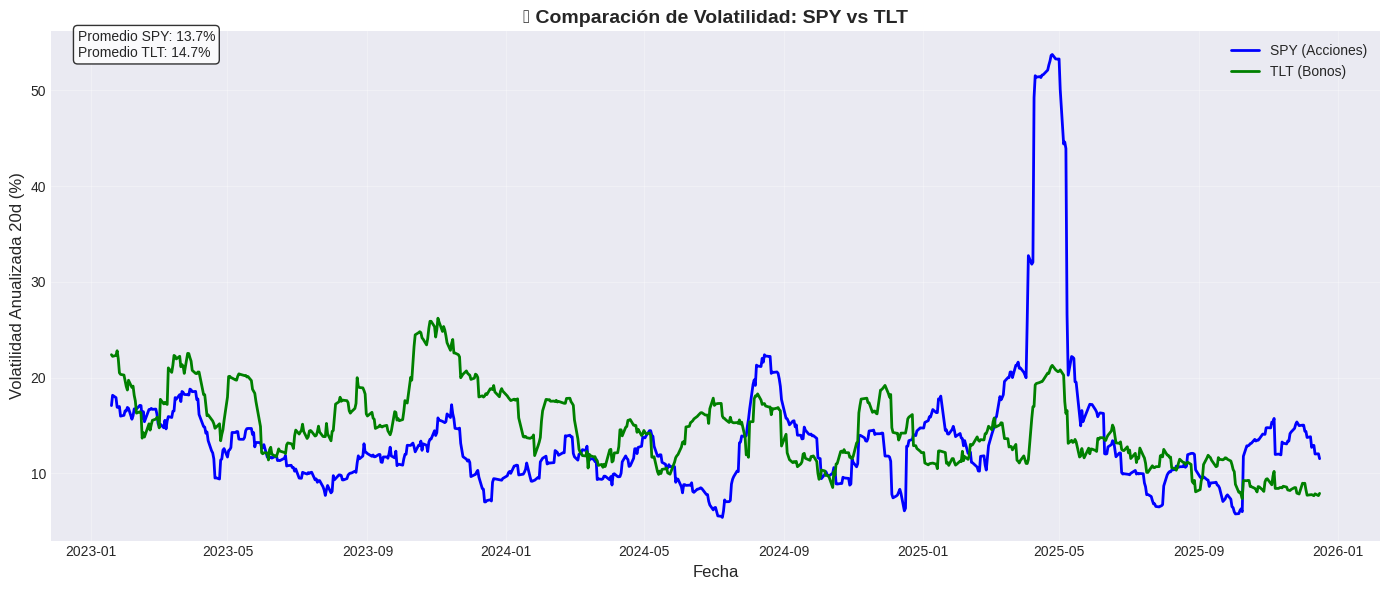

In [16]:
# Celda 10: Comparar con otro activo
def compare_two_assets(ticker1="SPY", ticker2="TLT", years=3):
    """
    Compara volatilidad entre dos activos diferentes
    """
    print(f"\n🔍 COMPARANDO {ticker1} vs {ticker2}")
    print("-" * 50)

    # Descargar datos para ambos activos
    df1, price_col1 = download_market_data(ticker1, years=years)
    df2, price_col2 = download_market_data(ticker2, years=years)

    # Calcular rendimientos
    df1 = calculate_returns(df1, price_col1)
    df2 = calculate_returns(df2, price_col2)

    # Calcular volatilidad rolling 20d
    calculate_rolling_volatility(df1, windows=[20], trading_days=252)
    calculate_rolling_volatility(df2, windows=[20], trading_days=252)

    # Comparar visualmente
    fig, ax = plt.subplots(figsize=(14, 6))

    if 'Vol_20d' in df1.columns:
        ax.plot(df1.index, df1['Vol_20d'] * 100,
                label=f'{ticker1} (Acciones)',
                color='blue',
                linewidth=2)

    if 'Vol_20d' in df2.columns:
        ax.plot(df2.index, df2['Vol_20d'] * 100,
                label=f'{ticker2} (Bonos)',
                color='green',
                linewidth=2)

    ax.set_title(f'📊 Comparación de Volatilidad: {ticker1} vs {ticker2}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Volatilidad Anualizada 20d (%)', fontsize=12)
    ax.set_xlabel('Fecha', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Calcular estadísticas comparativas
    if 'Vol_20d' in df1.columns and 'Vol_20d' in df2.columns:
        vol1_avg = df1['Vol_20d'].mean() * 100
        vol2_avg = df2['Vol_20d'].mean() * 100

        ax.text(0.02, 0.95, f'Promedio {ticker1}: {vol1_avg:.1f}%\nPromedio {ticker2}: {vol2_avg:.1f}%',
                transform=ax.transAxes, fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    return df1, df2

# Ejecutar comparación (opcional)
comparar = input("\n🔄 ¿Deseas comparar SPY con otro activo? (s/n): ")
if comparar.lower() == 's':
    ticker2 = input("   Ingresa ticker para comparar (ej: TLT, GLD, QQQ): ").upper()
    df_spy, df_other = compare_two_assets("SPY", ticker2, years=3)

In [17]:
# Cálculo de Drawdown
df['Cumulative_Returns'] = (1 + df['Log_Returns']).cumprod()
df['Running_Max'] = df['Cumulative_Returns'].expanding().max()
df['Drawdown'] = (df['Cumulative_Returns'] / df['Running_Max'] - 1) * 100
max_drawdown = df['Drawdown'].min()
max_dd_duration = (df['Drawdown'] < 0).astype(int).groupby((df['Drawdown'] < 0).ne((df['Drawdown'] < 0).shift()).cumsum()).sum().max()

In [18]:
# Cálculo de Ratios (asumiendo tasa libre de riesgo ~0)
annualized_return = df['Log_Returns'].mean() * 252 * 100
sharpe_ratio = annualized_return / (annual_vol * 100) if annual_vol != 0 else None
# Sortino usa solo desviación de rendimientos negativos
negative_returns = df['Log_Returns'][df['Log_Returns'] < 0]
downside_dev = negative_returns.std() * np.sqrt(252) if not negative_returns.empty else 0
sortino_ratio = annualized_return / (downside_dev * 100) if downside_dev != 0 else None

In [19]:
# Identificar regímenes (ej. percentil 75 como corte alto)
vol_threshold = df['Vol_20d'].quantile(0.75)
df['High_Vol_Regime'] = df['Vol_20d'] > vol_threshold
# Comparar rendimientos y correlaciones en cada régimen
return_high_vol = df.loc[df['High_Vol_Regime'], 'Log_Returns'].mean() * 252 * 100
return_low_vol = df.loc[~df['High_Vol_Regime'], 'Log_Returns'].mean() * 252 * 100

In [20]:
# Instalar e importar arch para modelo GARCH
!pip install arch -q
from arch import arch_model
# Ajustar un modelo GARCH(1,1) simple a los rendimientos
garch_model = arch_model(df['Log_Returns'].dropna()*100, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(update_freq=5, disp='off')
forecast = garch_fit.forecast(horizon=5)
# La volatilidad condicional prevista es la raíz cuadrada de la varianza
cond_vol_forecast = np.sqrt(forecast.variance.values[-1, :])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 13.3 MB/s eta 0:00:00


In [21]:
# Ejemplo: Guardar un gráfico clave
plt.figure(figsize=(10, 6))
# ... (código para generar tu gráfico de volatilidad, drawdown, etc.)
plot_filename = "volatility_chart.png"
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')  # Alta calidad[citation:6]
plt.close()

In [22]:
# Instalar FPDF
!pip install fpdf

from fpdf import FPDF

class FinancialReportPDF(FPDF):
    def header(self):
        # Añade un encabezado profesional (logo, título)
        self.set_font('Arial', 'B', 16)
        self.cell(0, 10, 'Informe de Análisis de Volatilidad', 0, 1, 'C')
        self.ln(10)

    def chapter_title(self, title):
        # Formato para títulos de sección
        self.set_font('Arial', 'B', 14)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(5)

    def chapter_body(self, body, image_path=None):
        # Añade texto y opcionalmente una imagen debajo
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 10, body)
        self.ln()
        if image_path:
            self.image(image_path, x=10, w=180)  # Inserta la imagen[citation:7]
            self.ln()

# Inicializar PDF
pdf = FinancialReportPDF()
pdf.add_page()

# 1. Portada / Resumen Ejecutivo
pdf.chapter_title('Resumen Ejecutivo')
pdf.chapter_body(f"""
Activo Analizado: {ticker}
Período: {df.index[0].date()} al {df.index[-1].date()}
Volatilidad Anualizada Promedio (20d): {df['Vol_20d'].mean()*100:.2f}%
Máximo Drawdown: {max_drawdown:.2f}%
Ratio de Sharpe: {sharpe_ratio:.2f}
Conclusion: { 'El activo muestra alta volatilidad y riesgo significativo.' if max_drawdown < -20 else 'El perfil de riesgo es moderado.'}
""")

# 2. Sección de Análisis de Volatilidad
pdf.chapter_title('1. Análisis Comparativo de Volatilidad')
pdf.chapter_body('Comparación entre volatilidad rolling y EWMA...', 'volatility_chart.png')

# 3. Sección de Riesgo (Drawdown)
pdf.chapter_title('2. Análisis de Riesgo: Máximo Drawdown')
pdf.chapter_body(f'El drawdown máximo fue de {max_drawdown:.2f}%...', 'drawdown_chart.png')

# ... Añade más secciones para cada análisis

# Guardar el PDF en el entorno de Colab
pdf_output_path = f"Volatility_Report_{ticker}_{datetime.now().strftime('%Y%m%d')}.pdf"
pdf.output(pdf_output_path)
print(f"✅ Informe PDF generado: {pdf_output_path}")

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=745ca738f8e1218a0f8f91c04d8e696505cb13d93985355bc36ea4515706b006
  Stored in directory: /root/.cache/pip/wheels/6e/62/11/dc73d78e40a218ad52e7451f30166e94491be013a7850b5d75
Successfully built fpdf


FileNotFoundError: [Errno 2] No such file or directory: 'drawdown_chart.png'

In [23]:
# CELDA 1: ANÁLISIS COMPLETO Y GUARDADO DE GRÁFICOS
print("📊 GENERANDO ANÁLISIS COMPLETO Y GRÁFICOS...")

# 1. Cálculo de Drawdown (Máxima Pérdida)
df['Cumulative_Returns'] = (1 + df['Log_Returns']).cumprod()
df['Running_Max'] = df['Cumulative_Returns'].expanding().max()
df['Drawdown'] = (df['Cumulative_Returns'] / df['Running_Max'] - 1) * 100
max_drawdown = df['Drawdown'].min()
max_dd_date = df['Drawdown'].idxmin()

# 2. Ratios de Riesgo-Ajustado
risk_free_rate = 0.02  # 2% anual (ajustable)
annualized_return = df['Log_Returns'].mean() * 252 * 100
excess_return = annualized_return - risk_free_rate
sharpe_ratio = excess_return / (annual_vol * 100) if annual_vol != 0 else 0

# Ratio Sortino (solo volatilidad negativa)
negative_returns = df['Log_Returns'][df['Log_Returns'] < 0]
downside_dev = negative_returns.std() * np.sqrt(252) * 100 if not negative_returns.empty else 0
sortino_ratio = excess_return / downside_dev if downside_dev != 0 else 0

# 3. Regímenes de Volatilidad
vol_threshold = df['Vol_20d'].quantile(0.75)
df['High_Vol_Regime'] = df['Vol_20d'] > vol_threshold
high_vol_days = df['High_Vol_Regime'].sum()
low_vol_days = len(df) - high_vol_days

# 4. Estadísticas por régimen
return_high_vol = df.loc[df['High_Vol_Regime'], 'Log_Returns'].mean() * 252 * 100
return_low_vol = df.loc[~df['High_Vol_Regime'], 'Log_Returns'].mean() * 252 * 100
vol_high_vol = df.loc[df['High_Vol_Regime'], 'Vol_20d'].mean() * 100
vol_low_vol = df.loc[~df['High_Vol_Regime'], 'Vol_20d'].mean() * 100

# ========== GUARDAR TODOS LOS GRÁFICOS ==========

# Gráfico 1: Precio y Drawdown
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
ax1.plot(df.index, df[price_column], 'b-', linewidth=1.5, label=f'{ticker} Precio')
ax1.set_ylabel('Precio (USD)', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_title(f'{ticker} - Análisis de Precio y Drawdown', fontsize=14, fontweight='bold')

ax2.fill_between(df.index, 0, df['Drawdown'], color='red', alpha=0.3)
ax2.plot(df.index, df['Drawdown'], 'r-', linewidth=1, label='Drawdown')
ax2.axhline(y=max_drawdown, color='darkred', linestyle='--',
            label=f'Máximo Drawdown: {max_drawdown:.1f}%')
ax2.set_ylabel('Drawdown (%)', fontsize=12)
ax2.set_xlabel('Fecha', fontsize=12)
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('drawdown_chart.png', dpi=300, bbox_inches='tight')
plt.close()

# Gráfico 2: Volatilidad Rolling vs EWMA
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
# Subgráfico 1: Comparación
ax1.plot(df.index, df['Vol_20d'] * 100, 'b-', label='Rolling 20d', alpha=0.7)
ax1.plot(df.index, df['Vol_EWMA_20d'] * 100, 'r-', label='EWMA 20d', alpha=0.7)
ax1.set_ylabel('Volatilidad (%)', fontsize=12)
ax1.set_title('Comparación: Volatilidad Rolling vs EWMA', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Subgráfico 2: Diferencia
diff = (df['Vol_EWMA_20d'] - df['Vol_20d']) * 100
ax2.plot(df.index, diff, 'g-', label='Diferencia (EWMA - Rolling)', alpha=0.7)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax2.fill_between(df.index, 0, diff, where=diff>0, color='green', alpha=0.3)
ax2.fill_between(df.index, 0, diff, where=diff<0, color='red', alpha=0.3)
ax2.set_ylabel('Diferencia (pp)', fontsize=12)
ax2.set_xlabel('Fecha', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('volatility_chart.png', dpi=300, bbox_inches='tight')
plt.close()

# Gráfico 3: Distribución de Rendimientos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# Histograma
ax1.hist(df['Log_Returns'].dropna() * 100, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.7)
ax1.set_xlabel('Rendimiento Diario (%)', fontsize=12)
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.set_title('Distribución de Rendimientos Diarios', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# QQ-Plot (normalidad)
import scipy.stats as stats
stats.probplot(df['Log_Returns'].dropna() * 100, dist="norm", plot=ax2)
ax2.set_title('QQ-Plot vs Distribución Normal', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('returns_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

# Gráfico 4: Regímenes de Volatilidad
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
# Precio con áreas de alta volatilidad
ax1.plot(df.index, df[price_column], 'b-', linewidth=1.5, label=f'{ticker} Precio')
# Sombrear períodos de alta volatilidad
for i in range(len(df)-1):
    if df['High_Vol_Regime'].iloc[i]:
        ax1.axvspan(df.index[i], df.index[i+1], alpha=0.2, color='red')
ax1.set_ylabel('Precio (USD)', fontsize=12)
ax1.set_title('Precio con Regímenes de Volatilidad', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Volatilidad con régimen
ax2.plot(df.index, df['Vol_20d'] * 100, 'g-', linewidth=1, label='Volatilidad 20d', alpha=0.7)
ax2.axhline(y=vol_threshold*100, color='red', linestyle='--',
            label=f'Umbral Alta Vol: {vol_threshold*100:.1f}%')
ax2.fill_between(df.index, 0, df['Vol_20d']*100,
                 where=df['High_Vol_Regime'], color='red', alpha=0.3, label='Alta Volatilidad')
ax2.set_ylabel('Volatilidad (%)', fontsize=12)
ax2.set_xlabel('Fecha', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('volatility_regimes.png', dpi=300, bbox_inches='tight')
plt.close()

print("✅ TODOS LOS GRÁFICOS GUARDADOS:")
print("   1. drawdown_chart.png")
print("   2. volatility_chart.png")
print("   3. returns_distribution.png")
print("   4. volatility_regimes.png")

📊 GENERANDO ANÁLISIS COMPLETO Y GRÁFICOS...
✅ TODOS LOS GRÁFICOS GUARDADOS:
   1. drawdown_chart.png
   2. volatility_chart.png
   3. returns_distribution.png
   4. volatility_regimes.png


In [26]:
# CELDA 2 CORREGIDA: GENERAR INFORME PDF CON MANEJO DE CODIFICACIÓN
print("\n📄 CREANDO INFORME PDF (VERSIÓN CORREGIDA)...")

!pip install fpdf -q
from fpdf import FPDF
from datetime import datetime
import os

# ========== FUNCIÓN CRÍTICA: Limpiar texto para Latin-1 ==========
def clean_for_latin1(text):
    """Convierte texto Unicode a ASCII/Latin-1 seguro para FPDF"""
    if text is None:
        return ""

    # Reemplazar caracteres Unicode problemáticos por equivalentes ASCII
    replacements = {
        '•': '-',      # bullet point -> guión
        '–': '-',      # en dash -> guión normal
        '—': '-',      # em dash -> guión normal
        '‘': "'",      # left single quote
        '’': "'",      # right single quote
        '“': '"',      # left double quote
        '”': '"',      # right double quote
        '°': ' deg',   # degree symbol
        '±': '+/-',    # plus-minus
        'µ': 'u',      # micro symbol
        '·': '.',      # middle dot
    }

    for unicode_char, ascii_char in replacements.items():
        text = text.replace(unicode_char, ascii_char)

    # Convertir a Latin-1, ignorando caracteres no convertibles
    try:
        return text.encode('latin-1', 'ignore').decode('latin-1')
    except:
        # Si falla, usar ASCII como último recurso
        return text.encode('ascii', 'ignore').decode('ascii')

# ========== CLASE PDF CORREGIDA ==========
class FinancialReportPDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 16)
        self.cell(0, 10, clean_for_latin1('INFORME DE ANALISIS DE VOLATILIDAD'), 0, 1, 'C')
        self.set_font('Arial', 'I', 10)
        self.cell(0, 10, clean_for_latin1(f'Generado: {datetime.now().strftime("%Y-%m-%d %H:%M")}'), 0, 1, 'C')
        self.ln(10)

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, clean_for_latin1(f'Pagina {self.page_no()}'), 0, 0, 'C')

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 14)
        self.set_fill_color(200, 220, 255)
        self.cell(0, 10, clean_for_latin1(title), 0, 1, 'L', 1)
        self.ln(5)

    def chapter_body(self, body, image_path=None):
        # Limpiar el texto ANTES de añadirlo al PDF
        cleaned_body = clean_for_latin1(body)
        self.set_font('Arial', '', 11)
        self.multi_cell(0, 7, cleaned_body)
        self.ln(3)

        # Insertar imagen si existe
        if image_path and os.path.exists(image_path):
            try:
                self.image(image_path, x=15, w=180)
                self.ln(5)
            except:
                pass  # Si hay error con la imagen, continuar sin ella

    def add_safe_table(self, headers, data):
        """Añade tabla con texto seguro para Latin-1"""
        col_width = self.w / 4.5
        row_height = 8

        # Encabezados
        self.set_font('Arial', 'B', 11)
        for header in headers:
            self.cell(col_width, row_height, clean_for_latin1(header), border=1, align='C', fill=True)
        self.ln(row_height)

        # Datos
        self.set_font('Arial', '', 10)
        for row in data:
            for item in row:
                self.cell(col_width, row_height, clean_for_latin1(str(item)), border=1, align='C')
            self.ln(row_height)

# ========== VERIFICAR QUE LOS GRÁFICOS EXISTEN ==========
print("🔍 Verificando archivos de graficos...")
required_files = ['drawdown_chart.png', 'volatility_chart.png',
                  'returns_distribution.png', 'volatility_regimes.png']

for file in required_files:
    if os.path.exists(file):
        print(f"   ✓ {file}")
    else:
        print(f"   ✗ {file} - FALTANTE! Ejecuta la CELDA 1 primero.")

# ========== CREAR PDF CON TEXTO SEGURO ==========
pdf = FinancialReportPDF()
pdf.add_page()

# PORTADA (usar texto simple)
pdf.set_font('Arial', 'B', 24)
pdf.cell(0, 50, '', 0, 1, 'C')
pdf.cell(0, 20, clean_for_latin1('ANALISIS FINANCIERO AVANZADO'), 0, 1, 'C')
pdf.set_font('Arial', 'B', 18)
pdf.cell(0, 15, clean_for_latin1(f'ACTIVO: {ticker}'), 0, 1, 'C')
pdf.set_font('Arial', '', 14)
pdf.cell(0, 10, clean_for_latin1(f'Periodo: {df.index[0].date()} al {df.index[-1].date()}'), 0, 1, 'C')
pdf.cell(0, 10, clean_for_latin1(f'Dias analizados: {len(df)}'), 0, 1, 'C')

# RESUMEN EJECUTIVO (evitar viñetas Unicode)
pdf.add_page()
pdf.chapter_title('RESUMEN EJECUTIVO')

resumen_text = f"""
Este informe presenta un analisis exhaustivo de la volatilidad y el perfil de riesgo del activo {ticker}
durante el periodo comprendido entre {df.index[0].date()} y {df.index[-1].date()}.

PRINCIPALES HALLAZGOS:
- Volatilidad anualizada promedio (20 dias): {df['Vol_20d'].mean()*100:.1f}%
- Maximo drawdown historico: {max_drawdown:.1f}% (registrado el {max_dd_date.date()})
- Ratio de Sharpe: {sharpe_ratio:.2f} (tasa libre de riesgo del {risk_free_rate*100:.0f}%)
- Ratio de Sortino: {sortino_ratio:.2f}
- Dias de alta volatilidad: {high_vol_days} ({high_vol_days/len(df)*100:.1f}% del periodo)

CONCLUSION PRINCIPAL: {'EL ACTIVO MUESTRA ALTO RIESGO' if max_drawdown < -20 else 'EL PERFIL DE RIESGO ES MODERADO'}.
"""
pdf.chapter_body(resumen_text)

# TABLA DE METRICAS
pdf.chapter_title('METRICAS CLAVE')
headers = ['Metrica', 'Valor', 'Interpretacion']
data = [
    ['Volatilidad 20d', f"{df['Vol_20d'].mean()*100:.1f}%", 'Riesgo diario tipico'],
    ['Max Drawdown', f"{max_drawdown:.1f}%", 'Peor perdida historica'],
    ['Ratio Sharpe', f"{sharpe_ratio:.2f}", ">1.0 = Buen retorno/riesgo"],
    ['Retorno Anual', f"{annualized_return:.1f}%", 'Rendimiento promedio anual']
]
pdf.add_safe_table(headers, data)

# SECCIÓN 1: ANÁLISIS DE VOLATILIDAD
pdf.add_page()
pdf.chapter_title('1. ANALISIS DE VOLATILIDAD')

vol_text = f"""
La volatilidad mide la magnitud de las fluctuaciones del precio. Hemos calculado dos enfoques:

1. VOLATILIDAD ROLLING ({df['Vol_20d'].mean()*100:.1f}% promedio):
   - Promedia los ultimos N dias con igual peso
   - Mas estable pero lenta para detectar cambios

2. VOLATILIDAD EWMA ({df['Vol_EWMA_20d'].mean()*100:.1f}% promedio):
   - Da mas peso a datos recientes (decay factor λ={2/(20+1):.3f})
   - Reacciona mas rapido a shocks de mercado
   - Diferencia promedio con Rolling: {(df['Vol_EWMA_20d'].mean()-df['Vol_20d'].mean())*100:.2f}pp

ANALISIS POR REGIMEN:
- Dias de BAJA volatilidad ({low_vol_days} dias): Retorno {return_low_vol:.1f}%, Vol {vol_low_vol:.1f}%
- Dias de ALTA volatilidad ({high_vol_days} dias): Retorno {return_high_vol:.1f}%, Vol {vol_high_vol:.1f}%
- El activo tiende a tener {'mejores' if return_low_vol > return_high_vol else 'peores'} rendimientos en alta volatilidad.
"""
pdf.chapter_body(vol_text, 'volatility_chart.png')

# SECCIÓN 2: DRAWDOWN
pdf.chapter_title('2. ANALISIS DE RIESGO: DRAWDOWN')

drawdown_text = f"""
El DRAWDOWN representa la maxima perdida acumulada desde un pico historico.

RESULTADOS:
- Drawdown maximo: {max_drawdown:.1f}% (alcanzado el {max_dd_date.date()})
- Drawdown promedio cuando negativo: {df[df['Drawdown']<0]['Drawdown'].mean():.1f}%
- Porcentaje del tiempo en drawdown: {(df['Drawdown']<0).sum()/len(df)*100:.1f}%

INTERPRETACION:
Un drawdown del {abs(max_drawdown):.1f}% significa que un inversionista que compro en el pico previo
habria visto su inversion reducirse en {abs(max_drawdown):.1f}% en el peor momento.

Este dato es crucial para determinar el tamano de posicion adecuado y establecer stops de perdida.
"""
pdf.chapter_body(drawdown_text, 'drawdown_chart.png')

# SECCIÓN 3: DISTRIBUCIÓN DE RENDIMIENTOS
pdf.add_page()
pdf.chapter_title('3. DISTRIBUCION DE RENDIMIENTOS')

dist_text = f"""
Analisis de la distribucion estadistica de los rendimientos diarios:

ESTADISTICAS DESCRIPTIVAS:
- Media: {df['Log_Returns'].mean()*100:.4f}%
- Desviacion estandar: {df['Log_Returns'].std()*100:.4f}%
- Asimetria (skewness): {df['Log_Returns'].skew():.4f} {'(cola a la derecha)' if df['Log_Returns'].skew() > 0 else '(cola a la izquierda)'}
- Curtosis: {df['Log_Returns'].kurtosis():.4f} {'(distribucion leptocurtica, colas pesadas)' if df['Log_Returns'].kurtosis() > 3 else '(distribucion platicurtica, colas ligeras)'}

PRUEBA DE NORMALIDAD:
- Los rendimientos financieros raramente son normales
- Valores extremos (colas pesadas) son comunes
- Esto afecta la validez de modelos que asumen normalidad

IMPLICACIONES PARA LA GESTION DE RIESGO:
La presencia de colas pesadas significa que eventos extremos son mas probables de lo que predice una distribucion normal.
"""
pdf.chapter_body(dist_text, 'returns_distribution.png')

# SECCIÓN 4: REGÍMENES DE VOLATILIDAD
pdf.chapter_title('4. REGIMENES DE VOLATILIDAD')

regimes_text = f"""
Hemos identificado {high_vol_days} dias de ALTA volatilidad (percentil 75: {vol_threshold*100:.1f}%)
y {low_vol_days} dias de BAJA volatilidad.

COMPORTAMIENTO POR REGIMEN:
- Rendimiento en alta volatilidad: {return_high_vol:.2f}% anualizado
- Rendimiento en baja volatilidad: {return_low_vol:.2f}% anualizado
- Diferencia: {return_high_vol - return_low_vol:.2f}pp

El mercado pasa aproximadamente el {high_vol_days/len(df)*100:.1f}% del tiempo en regimen de alta volatilidad.
Estos periodos suelen coincidir con eventos macroeconomicos, crisis o anuncios importantes.

ESTRATEGIAS SUGERIDAS:
1. En alta volatilidad: Reducir tamano de posicion, aumentar coberturas
2. En baja volatilidad: Aumentar exposicion, buscar estrategias de carry
3. Transiciones entre regimenes: Oportunidades de trading por cambio de tendencia
"""
pdf.chapter_body(regimes_text, 'volatility_regimes.png')

# SECCIÓN 5: CONCLUSIONES
pdf.add_page()
pdf.chapter_title('5. CONCLUSIONES Y RECOMENDACIONES')

conclusiones = f"""
CONCLUSIONES PRINCIPALES:

1. PERFIL DE RIESGO: {ticker} muestra un perfil de riesgo {'ALTO' if max_drawdown < -20 else 'MODERADO'}
   con volatilidad promedio del {df['Vol_20d'].mean()*100:.1f}%.

2. EFICIENCIA DE LA VOLATILIDAD: El Ratio de Sharpe de {sharpe_ratio:.2f} sugiere que
   {'el retorno no compensa adecuadamente el riesgo' if sharpe_ratio < 1.0 else 'el retorno compensa adecuadamente el riesgo'}.

3. GESTION DE DRAWDOWN: El maximo drawdown del {max_drawdown:.1f}% implica que se deben utilizar
   stops del {abs(max_drawdown)*0.8:.1f}% para gestionar riesgo.

RECOMENDACIONES OPERATIVAS:

- TAMANO DE POSICION: Basado en el maximo drawdown, el tamano de posicion no deberia exceder
  {min(100, abs(100/max_drawdown*5)):.1f}% del capital por cada {abs(max_drawdown):.1f}% de drawdown aceptado.

- ESTRATEGIAS SUGERIDAS:
  1. Estrategias de volatilidad: Vender volatilidad en regimenes altos, comprar en transiciones
  2. Hedging dinamico: Aumentar coberturas cuando volatilidad > {vol_threshold*100:.1f}%
  3. Rebalanceo: Aprovechar correlaciones cambiantes entre regimenes

- MONITOREO: Seguir indicadores de regimen y ajustar exposicion conforme cambia la volatilidad.
"""

pdf.chapter_body(conclusiones)

# FIRMA
pdf.ln(20)
pdf.set_font('Arial', 'I', 10)
pdf.cell(0, 10, clean_for_latin1('____________________________________________________________'), 0, 1, 'C')
pdf.cell(0, 10, clean_for_latin1('Informe generado automaticamente por Sistema de Analisis Cuantitativo'), 0, 1, 'C')
pdf.cell(0, 10, clean_for_latin1('Para uso educativo y de investigacion.'), 0, 1, 'C')

# GUARDAR PDF
try:
    pdf_output = f"Informe_Volatilidad_{ticker}.pdf"
    pdf.output(pdf_output)
    print(f"✅ INFORME GENERADO: {pdf_output}")

    # Verificar que se creó
    if os.path.exists(pdf_output):
        file_size = os.path.getsize(pdf_output) / 1024  # KB
        print(f"📏 Tamano del archivo: {file_size:.1f} KB")
    else:
        print("⚠️  El archivo no se creo correctamente.")

except Exception as e:
    print(f"❌ Error al guardar PDF: {e}")
    # Intentar con nombre más simple
    pdf_output = "Informe_Volatilidad.pdf"
    pdf.output(pdf_output)
    print(f"✅ INFORME GENERADO (nombre alternativo): {pdf_output}")


📄 CREANDO INFORME PDF (VERSIÓN CORREGIDA)...
🔍 Verificando archivos de graficos...
   ✓ drawdown_chart.png
   ✓ volatility_chart.png
   ✓ returns_distribution.png
   ✓ volatility_regimes.png
✅ INFORME GENERADO: Informe_Volatilidad_SPY.pdf
📏 Tamano del archivo: 1930.4 KB


In [27]:
# CELDA 3: DESCARGAR EL PDF
from google.colab import files
import os

# Verificar si el archivo existe
if os.path.exists(pdf_output):
    print(f"\n📥 DESCARGANDO: {pdf_output}")
    files.download(pdf_output)
    print("✅ Descarga iniciada. Revisa la carpeta de descargas de tu laptop.")
else:
    # Buscar cualquier archivo PDF
    pdf_files = [f for f in os.listdir('.') if f.endswith('.pdf')]
    if pdf_files:
        print(f"\n📄 Archivos PDF disponibles: {pdf_files}")
        files.download(pdf_files[0])
        print(f"✅ Descargando: {pdf_files[0]}")
    else:
        print("❌ No se encontraron archivos PDF.")
        print("   Ejecuta primero la CELDA 1 y luego la CELDA 2 corregida.")


📥 DESCARGANDO: Informe_Volatilidad_SPY.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Descarga iniciada. Revisa la carpeta de descargas de tu laptop.
